# Cyclistic Bike-share Analysis Case Study
#### Michael Lee
#### 6/8/2025

## Scenario
You are a junior data analyst working on the marketing analytics team at Cyclistic, a fictional bike-share company in Chicago. The company offers flexible pricing plans: single-ride, full-day passes, and annual memberships.

The marketing director, Lily Moreno, believes future growth depends on converting casual riders (those who use single-ride and day passes) into annual members. Your team has been tasked with analyzing trip data to uncover how casual riders and annual members use Cyclistic bikes differently. These insights will inform marketing strategies aimed at increasing memberships.

## 01. ASK - Identify business task

**Guiding question**: How do we convert casual riders into annual members?

**Business task**: Analyze how casual riders and annual members use Cyclistic bikes differently to support a marketing strategy that converts casual riders into annual members.

**Key stakeholders**: Lily Moreno (Director of marketing), Cyclistic executives, marketing analytics team, customers

## 02. PREPARE - Load the datasets and verify data integrity

In [107]:
# Import necessary packages
import pandas as pd
import zipfile
import os
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import folium
from folium.plugins import MarkerCluster

Instead of manually unzipping and modifying each file, opting to access the data in its zipped format offers a more efficient process. Not only is it quicker, it also avoids any risks of data loss when unzipping and saving in different formats.

In [108]:
# Path to folder with downloaded Divvy data zip files
zip_folder = '../Datasets/zip_files/'
    
# Get all zip files in the folder
zip_files = [f for f in os.listdir(zip_folder) if f.endswith('.zip')]
# To store dataframes
df_dict = {}

# Loop through each zip file and load the CSVs
for zip_file in zip_files:
    zip_path = os.path.join(zip_folder, zip_file)
    with zipfile.ZipFile(zip_path, 'r') as z:
        for filename in z.namelist():
            if filename.endswith('.csv') and not filename.startswith('__MACOSX/'):
                df = pd.read_csv(z.open(filename))
                # Extract the YYMM from the filename for key
                base_name = os.path.splitext(zip_file)[0] 
                yyyymm = base_name.split('-')[0] 
                key = f"df_{yyyymm[2:]}"
                df_dict[key] = df
                break

print(df_dict.keys()) # List each key (dataset) in the dictionary

dict_keys(['df_2405', 'df_2406', 'df_2407', 'df_2408', 'df_2409', 'df_2410', 'df_2411', 'df_2412', 'df_2501', 'df_2502', 'df_2503', 'df_2504'])


A quick look at one of the datasets:

In [3]:
df_dict['df_2405'].head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,7D9F0CE9EC2A1297,classic_bike,2024-05-25 15:52:42,2024-05-25 16:11:50,Streeter Dr & Grand Ave,13022,Clark St & Elm St,TA1307000039,41.892278,-87.612043,41.902973,-87.631280,casual
1,02EC47687411416F,classic_bike,2024-05-14 15:11:51,2024-05-14 15:22:00,Sheridan Rd & Greenleaf Ave,KA1504000159,Sheridan Rd & Loyola Ave,RP-009,42.010587,-87.662412,42.001044,-87.661198,casual
2,101370FB2D3402BE,classic_bike,2024-05-30 17:46:04,2024-05-30 18:09:16,Streeter Dr & Grand Ave,13022,Wabash Ave & 9th St,TA1309000010,41.892278,-87.612043,41.870769,-87.625734,member
3,E97E396331ED6913,electric_bike,2024-05-17 20:21:54,2024-05-17 20:40:32,Streeter Dr & Grand Ave,13022,Sheffield Ave & Wellington Ave,TA1307000052,41.892270,-87.611946,41.936253,-87.652662,member
4,674EDE311C543165,classic_bike,2024-05-22 18:52:20,2024-05-22 18:59:04,Larrabee St & Division St,KA1504000079,Clark St & Elm St,TA1307000039,41.903486,-87.643353,41.902973,-87.631280,casual


## 03. PROCESS - Clean and modify each dataframe to prep for analysis

In [4]:
for key, df in df_dict.items(): # Loop through each df to clean and add columns
    # Convert to datetime format, if not already
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])

    # Add ride_length column to calculate the length of each trip
    df['ride_length'] = df['ended_at'] - df['started_at']
    
    # Add day_of_week column (Sunday = 1 to Saturday = 7)
    # Default is Monday = 0 to Sunday = 6, so we need to adjust
    df['day_of_week'] = (df['started_at'].dt.dayofweek + 1) % 7 + 1 
    
    print(f"\n--- {key} ---")
    # Missing values per column
    print("Missing values:")
    null_sum = df.isnull().sum()
    if null_sum.sum() > 0:
        print(null_sum[null_sum > 0])
   
    # Rows with missing values
    rows_missing = df.isnull().any(axis=1).sum()
    print(f"Rows with missing values: {rows_missing / len(df) * 100:.2f}%")

    # Number of duplicate rows
    duplicate_count = df.duplicated().sum()
    print(f"Duplicate rows: {duplicate_count}")


--- df_2405 ---
Missing values:
start_station_name    109048
start_station_id      109048
end_station_name      112731
end_station_id        112731
end_lat                  784
end_lng                  784
dtype: int64
Rows with missing values: 27.45%
Duplicate rows: 0

--- df_2406 ---
Missing values:
start_station_name    144025
start_station_id      144025
end_station_name      148027
end_station_id        148027
end_lat                 1124
end_lng                 1124
dtype: int64
Rows with missing values: 30.45%
Duplicate rows: 0

--- df_2407 ---
Missing values:
start_station_name    136965
start_station_id      136965
end_station_name      139224
end_station_id        139224
end_lat                 1091
end_lng                 1091
dtype: int64
Rows with missing values: 27.78%
Duplicate rows: 0

--- df_2408 ---
Missing values:
start_station_name    140591
start_station_id      140591
end_station_name      142225
end_station_id        142225
end_lat                 1027
end_lng  

All datasets contain values for the `started_at` and `ended_at` columns, which ensures that our calculated time-based columns (e.g., ride duration, day of week) will be complete for every entry.

However, many missing values are found in the station name and location columns. While we can still include station and geographic analysis, it’s important to acknowledge the limitations and potential inaccuracies this missing data introduces when evaluating station-level or location-based trends.

Another look at the same dataset after modifying:

In [5]:
df_dict['df_2405'].head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_length,day_of_week
0,7D9F0CE9EC2A1297,classic_bike,2024-05-25 15:52:42,2024-05-25 16:11:50,Streeter Dr & Grand Ave,13022,Clark St & Elm St,TA1307000039,41.892278,-87.612043,41.902973,-87.631280,casual,0 days 00:19:08,7
1,02EC47687411416F,classic_bike,2024-05-14 15:11:51,2024-05-14 15:22:00,Sheridan Rd & Greenleaf Ave,KA1504000159,Sheridan Rd & Loyola Ave,RP-009,42.010587,-87.662412,42.001044,-87.661198,casual,0 days 00:10:09,3
2,101370FB2D3402BE,classic_bike,2024-05-30 17:46:04,2024-05-30 18:09:16,Streeter Dr & Grand Ave,13022,Wabash Ave & 9th St,TA1309000010,41.892278,-87.612043,41.870769,-87.625734,member,0 days 00:23:12,5
3,E97E396331ED6913,electric_bike,2024-05-17 20:21:54,2024-05-17 20:40:32,Streeter Dr & Grand Ave,13022,Sheffield Ave & Wellington Ave,TA1307000052,41.892270,-87.611946,41.936253,-87.652662,member,0 days 00:18:38,6
4,674EDE311C543165,classic_bike,2024-05-22 18:52:20,2024-05-22 18:59:04,Larrabee St & Division St,KA1504000079,Clark St & Elm St,TA1307000039,41.903486,-87.643353,41.902973,-87.631280,casual,0 days 00:06:44,4


We added two new columns to the dataset:  
- `ride_length` – Calculates the duration of each bike trip  
- `day_of_week` – Identifies which day of the week the trip occurred

In [6]:
# Merge the processed dataframes into one
combined_df = pd.concat(df_dict.values(), ignore_index=True)

print('Columns and datatypes in combined_df:')
print(combined_df.info())

Columns and datatypes in combined_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5735884 entries, 0 to 5735883
Data columns (total 15 columns):
 #   Column              Dtype          
---  ------              -----          
 0   ride_id             object         
 1   rideable_type       object         
 2   started_at          datetime64[ns] 
 3   ended_at            datetime64[ns] 
 4   start_station_name  object         
 5   start_station_id    object         
 6   end_station_name    object         
 7   end_station_id      object         
 8   start_lat           float64        
 9   start_lng           float64        
 10  end_lat             float64        
 11  end_lng             float64        
 12  member_casual       object         
 13  ride_length         timedelta64[ns]
 14  day_of_week         int32          
dtypes: datetime64[ns](2), float64(4), int32(1), object(7), timedelta64[ns](1)
memory usage: 634.5+ MB
None


In [96]:
print(combined_df['ride_length'].describe())

count                      5735884
mean     0 days 00:16:53.380948522
std      0 days 00:58:33.459480860
min              -2 days +02:11:41
25%         0 days 00:05:29.242000
50%         0 days 00:09:37.130500
75%         0 days 00:17:03.511250
max         1 days 01:59:55.072000
Name: ride_length, dtype: object


The shortest recorded trip duration is around `-2 days`, which is not possible. This likely resulted from a data entry error or system malfunction. To ensure data accuracy, we will remove this entry from our analysis and check for additional outliers.

In [109]:
# Trips < 60s
short_rides = combined_df[combined_df['ride_length'].dt.total_seconds() < 60]
# Count
print(f"Number of rides shorter than 60 seconds: {len(short_rides)}")

Number of rides shorter than 60 seconds: 126460


In [116]:
print(f'Rows in combined_df: {len(combined_df)}')
# Remove entries where ride_length < 60s
filtered_df = combined_df[combined_df['ride_length'].dt.total_seconds() >= 60]
print(f'Rows in filtered_df: {len(filtered_df)}')
count_removed_rows = len(combined_df) - len(filtered_df)
percent_rows = round((count_removed_rows / len(combined_df)) * 100, 2)
print(f'Percent of rows removed: {percent_rows}%')

Rows in combined_df: 5735884
Rows in filtered_df: 5609424
Percent of rows removed: 2.2%


As stated by Lyft:
    
    "The data has been processed to remove trips that are taken by staff as they service and inspect the system; and any trips that were below 60 seconds in length (potentially false starts or users trying to re-dock a bike to ensure it was secure)."

However, some records with ride durations under 60 seconds are still present in the datasets, suggesting they may have been overlooked. To ensure data quality and consistency, we removed these trips, which resulted in a reduction of approximately 2.2% of total rows.

In [117]:
# 99th percentile ride duration in minutes
max_cutoff = combined_df['ride_length_minutes'].quantile(0.99)
print(f"99th percentile cutoff: {max_cutoff:.2f} minutes")

# Filter out top 1% of rides (possible outliers)
filtered_df = filtered_df[filtered_df['ride_length_minutes'] <= cutoff]

99th percentile cutoff: 98.57 minutes


Additionally, we removed the top 1% of rides with unusually long durations to ensure the accuracy of our analysis. These extreme outliers may be the result of errors such as bikes not being properly docked or trips that were not correctly ended. Including them could skew our average ride length and other time-based metrics.

By filtering out these outliers, we retain 99% of the data, which gives us a more reliable representation of typical rider behavior. Now that our data has been properly cleaned and processed, we can begin the analysis phase.

## 04. ANALYZE - Explore data, perform calculations, identify trends
## 05. SHARE - Create supporting visualizations to share findings
  
**Consider**: How do members vs. casual riders use the bikes differently?

In [118]:
print(filtered_df['ride_length'].describe())

count                      5552065
mean     0 days 00:13:46.394689607
std      0 days 00:12:53.637948214
min                0 days 00:01:00
25%         0 days 00:05:41.374000
50%         0 days 00:09:44.479000
75%         0 days 00:16:57.949000
max         0 days 01:38:34.120000
Name: ride_length, dtype: object


A quick overview of the data gives us a general understanding of its structure, but to address the business question, we need to focus on how casual riders and members differ in their behavior.

In [119]:
# Group by summary stats
print(filtered_df.groupby('member_casual')['ride_length'].describe())

                 count                       mean                        std  \
member_casual                                                                  
casual         1999238  0 days 00:17:33.117231485  0 days 00:16:23.267721260   
member         3552827  0 days 00:11:38.813943013  0 days 00:09:48.272796648   

                           min                     25%  \
member_casual                                            
casual         0 days 00:01:00  0 days 00:06:55.448250   
member         0 days 00:01:00  0 days 00:05:11.346000   

                                  50%                     75%  \
member_casual                                                   
casual         0 days 00:12:01.367500  0 days 00:21:48.163750   
member         0 days 00:08:44.015000  0 days 00:14:43.546000   

                                  max  
member_casual                          
casual         0 days 01:38:34.120000  
member         0 days 01:38:34.053000  


This summary provides insights into how ride lengths differ between casual riders and members:

- The majority of rides are taken by **members**
- **Casual riders** tend to take longer trips than **members** on average (~17 minutes vs ~11 minutes)
- **Members** show more consistent ride durations, indicated by a lower standard deviation and a tighter range between the 25th and 75th percentiles
- The maximum ride duration for both groups is now under 1 hour 40 minutes for both groups, which is much more realistic than before filtering

We can split the dataframe into two different sets for members and casual riders for further exploration.

In [120]:
member_df = filtered_df[filtered_df['member_casual'] == 'member'].copy() # Filter for members
casual_df = filtered_df[filtered_df['member_casual'] == 'casual'].copy() # Filter for casual riders

### Members vs. Casual Riders Trends

#### Month Counts

In [121]:
member_df['start_month'] = member_df['started_at'].dt.month
member_month_counts = member_df['start_month'].value_counts()
print(f'Most active months for members:\n{member_month_counts}')


Most active months for members:
start_month
9     464648
8     429117
7     420732
6     400951
10    393868
5     369035
4     257388
11    238243
3     207927
12    137137
2     121787
1     111994
Name: count, dtype: int64


In [122]:
casual_df['start_month'] = casual_df['started_at'].dt.month
casual_month_counts = casual_df['start_month'].value_counts()
print(f'Most active months for casual riders:\n{casual_month_counts}')


Most active months for casual riders:
start_month
9     328650
7     301431
8     300487
6     282743
5     217183
10    206266
4     103757
11     89574
3      82019
12     37080
2      26823
1      23225
Name: count, dtype: int64


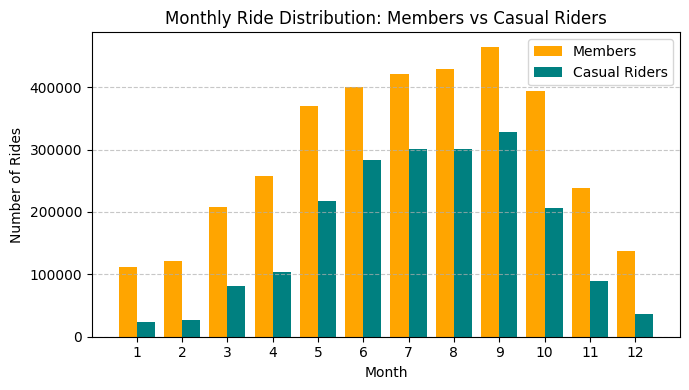

In [123]:
# Sort months in order
member_month_counts = member_month_counts.sort_index()
casual_month_counts = casual_month_counts.sort_index()

months = np.array(range(1, 13))
bar_width = 0.
# Plot
plt.figure(figsize=(7, 4))
plt.bar(months - bar_width/2, member_month_counts.values, width=bar_width, label='Members', color='orange')
plt.bar(months + bar_width/2, casual_month_counts.values, width=bar_width, label='Casual Riders', color='teal')
plt.xlabel('Month')
plt.ylabel('Number of Rides')
plt.title('Monthly Ride Distribution: Members vs Casual Riders')
plt.xticks(range(1, 13))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

The monthly ride distribution follows a similar pattern for both groups, with peaks in the summer and fall and fewer rides during the winter months. This trend is likely a result of seasonal changes in weather and riding conditions.

It's important to note that members have a higher total ride count across all months because members make up more than 60% of the data. To meaningfully compare behaviors between groups, we need to use a normalized version of the chart that accounts for differences in group sizes and highlights relative trends.

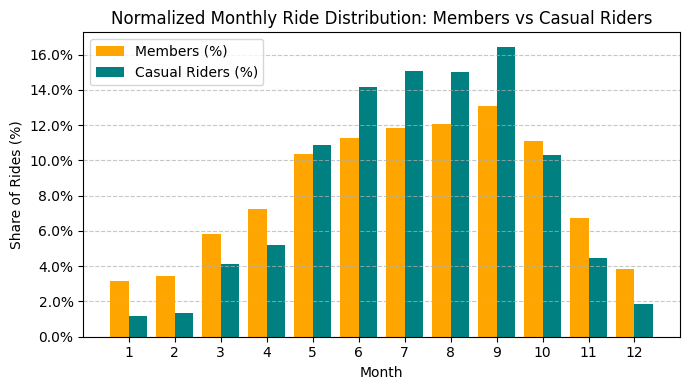

In [124]:
# Sort months in order
member_month_counts = member_month_counts.sort_index()
casual_month_counts = casual_month_counts.sort_index()
# Normalize monthly counts
member_month_pct = member_month_counts / member_month_counts.sum()
casual_month_pct = casual_month_counts / casual_month_counts.sum()

months = np.array(range(1, 13))
bar_width = 0.4
# Plot
plt.figure(figsize=(7, 4))
plt.bar(months - bar_width/2, member_month_pct.values, width=bar_width, label='Members (%)', color='orange')
plt.bar(months + bar_width/2, casual_month_pct.values, width=bar_width, label='Casual Riders (%)', color='teal')
plt.xlabel('Month')
plt.ylabel('Share of Rides (%)')
plt.title('Normalized Monthly Ride Distribution: Members vs Casual Riders')
plt.xticks(range(1, 13))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
plt.show()

In this normalized version, casual riders show a higher proportion of their annual rides occurring in the summer and fall compared to members. In contrast, members have a higher proportion during the winter. This suggests a more need-basis for members, even during months with poor weather conditions, whereas casual riders are more likely to ride for leisure and during more favorable weather.

#### Day Counts

In [126]:
member_day_counts = member_df['day_of_week'].value_counts()
print(f'Most popular days for members:\n{member_day_counts}')

Most popular days for members:
day_of_week
4    583512
5    548406
3    540340
6    520841
2    506721
7    459253
1    393754
Name: count, dtype: int64


Members prefer to use bikes during the week with Wednesdays having the highest count.

In [127]:
casual_day_counts = casual_df['day_of_week'].value_counts()
print(f'Most popular days for casual riders:\n{casual_day_counts}')

Most popular days for casual riders:
day_of_week
7    407787
1    332283
6    308365
4    253891
5    250634
2    232203
3    214075
Name: count, dtype: int64


Weekends are favored amongst casual riders with Saturdays having the highest count.

Similarly with the months, we need to look at the normalized version of daily rides.

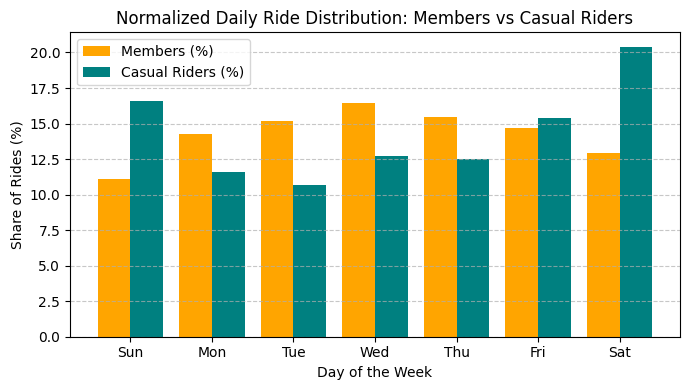

In [128]:
# Sort day counts by day index (1=Mon to 7=Sun or similar)
member_day_counts = member_day_counts.sort_index()
casual_day_counts = casual_day_counts.sort_index()

# Normalize to get share of weekly rides
member_day_pct = (member_day_counts / member_day_counts.sum()) * 100
casual_day_pct = (casual_day_counts / casual_day_counts.sum()) * 100

# X-axis positions
days = np.array(range(1, 8))  # Days 1 through 7
bar_width = 0.4

# Plot
plt.figure(figsize=(7, 4))
plt.bar(days - bar_width/2, member_day_pct.values, width=bar_width, label='Members (%)', color='orange')
plt.bar(days + bar_width/2, casual_day_pct.values, width=bar_width, label='Casual Riders (%)', color='teal')

# Labels and title
plt.xlabel('Day of the Week')
plt.ylabel('Share of Rides (%)')
plt.title('Normalized Daily Ride Distribution: Members vs Casual Riders')
plt.xticks(days, ['Sun','Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

Members tend to ride more consistently throughout the workweek, peaking mid-week on Wednesdays. In contrast, casual riders show a strong preference for weekends, with Saturdays accounting for over 20% of their weekly rides. This pattern reinforces the idea that casual users likely ride for leisure, while members use the service more for commuting or routine travel.

#### Hour Counts

In [129]:
member_df['start_hour'] = member_df['started_at'].dt.hour
member_hour_counts = member_df['start_hour'].value_counts()
print(f'\nMost common start times for members:\n{member_hour_counts}')


Most common start times for members:
start_hour
17    376388
16    329898
18    294668
8     247666
15    240028
19    206785
12    194680
7     193772
14    193631
13    193228
11    170793
9     168293
10    146608
20    144062
21    110997
6      99419
22     80420
23     50376
5      33538
0      31263
1      19263
2      11033
4       8332
3       7686
Name: count, dtype: int64


In [130]:
# Calculate most active hours for both groups
casual_df['start_hour'] = casual_df['started_at'].dt.hour
casual_hour_counts = casual_df['start_hour'].value_counts()
print(f'\nMost common start times for casual riders:\n{casual_hour_counts}')


Most common start times for casual riders:
start_hour
17    191092
16    177581
18    163827
15    156483
14    140977
13    134620
12    129478
19    120238
11    109883
20     88181
10     85942
21     73479
8      72293
9      71240
22     64196
7      51250
23     44861
0      33560
6      27778
1      22424
2      14141
5      11489
3       7884
4       6341
Name: count, dtype: int64


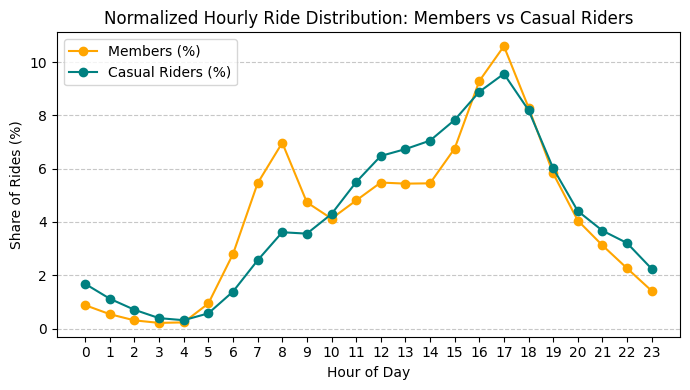

In [131]:
member_hour_counts = member_hour_counts.sort_index()
casual_hour_counts = casual_hour_counts.sort_index()

# Normalize to percent of total rides per group
member_hour_pct = (member_hour_counts / member_hour_counts.sum()) * 100
casual_hour_pct = (casual_hour_counts / casual_hour_counts.sum()) * 100

# Plot
plt.figure(figsize=(7, 4))
plt.plot(member_hour_pct.index, member_hour_pct.values, marker='o', label='Members (%)', color='orange')
plt.plot(casual_hour_pct.index, casual_hour_pct.values, marker='o', label='Casual Riders (%)', color='teal')

plt.xlabel('Hour of Day')
plt.ylabel('Share of Rides (%)')
plt.title('Normalized Hourly Ride Distribution: Members vs Casual Riders')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

Both groups prefer to ride at similar hours. We see a peak in afternoon times around 5 PM for both members and casual riders. However, one distinction is that there is another peak in the morning around 8 AM as well for members, while the proportion of rides for casual riders is lower.

By analyzing the data by month, day of week, and hour of day, the data suggests that members are more likely using the bikes for commuting purposes whereas casual riders exhibit patterns indicating leisure-based usage.

#### Ride Types

In [132]:
member_ridetype_counts = member_df['rideable_type'].value_counts()
print(f'\nMost popular ride types for members:\n{member_ridetype_counts}')


Most popular ride types for members:
rideable_type
electric_bike       1894771
classic_bike        1601931
electric_scooter      56125
Name: count, dtype: int64


In [133]:
# Calculate most popular ride type for both groups
casual_ridetype_counts = casual_df['rideable_type'].value_counts()
print(f'\nMost popular ride types for casual riders:\n{casual_ridetype_counts}')


Most popular ride types for casual riders:
rideable_type
electric_bike       1036915
classic_bike         881125
electric_scooter      81198
Name: count, dtype: int64


Electric bikes were most popular amongst both groups most likely for their speed and ease of use.